## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os, fnmatch
import glob
%matplotlib inline

save_path = './output_images/'

Could not find corners. Image name is ./camera_cal/calibration1.jpg
Successfully loaded ./camera_cal/calibration10.jpg
Successfully loaded ./camera_cal/calibration11.jpg
Successfully loaded ./camera_cal/calibration12.jpg
Successfully loaded ./camera_cal/calibration13.jpg
Successfully loaded ./camera_cal/calibration14.jpg
Successfully loaded ./camera_cal/calibration15.jpg
Successfully loaded ./camera_cal/calibration16.jpg
Successfully loaded ./camera_cal/calibration17.jpg
Successfully loaded ./camera_cal/calibration18.jpg
Successfully loaded ./camera_cal/calibration19.jpg
Successfully loaded ./camera_cal/calibration2.jpg
Successfully loaded ./camera_cal/calibration20.jpg
Successfully loaded ./camera_cal/calibration3.jpg
Could not find corners. Image name is ./camera_cal/calibration4.jpg
Could not find corners. Image name is ./camera_cal/calibration5.jpg
Successfully loaded ./camera_cal/calibration6.jpg
Successfully loaded ./camera_cal/calibration7.jpg
Successfully loaded ./camera_cal/ca

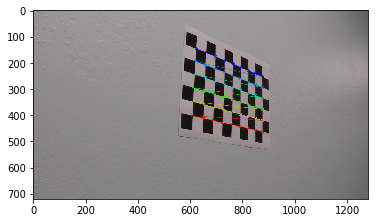

In [ ]:
# camera calibration

# read in camera calibration images
cam_cal_imgs = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points
nx = 9 # Chessboard size is 9x6
ny = 6 # Chessboard size is 9x6

obj_points = [] # object points
img_points = [] # image points

# prepare object points
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in cam_cal_imgs:

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # append detected corners to the image points
        img_points.append(corners)
        obj_points.append(objp)
    
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        print('Successfully loaded {}'.format(fname))
    else:
        print('Could not find corners. Image name is {}'.format(fname))

        #cv2.destroyAllWindows()

In [ ]:
# use the first image as test image
img = cv2.imread(cam_cal_imgs[0])
shape = img.shape[0:2]

# perform camera calibration
# return value, camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, cam_mat, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, shape, None, None)

# undistort image
undistorted = cv2.undistort(img, cam_mat, dist_coeff)

# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# unwarp images
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    if(ret):
        img_size = (gray.shape[::-1])
        offset = 100
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # dst = np.float32([[100, 100],[1100, 100],[1100, 900],[100, 900]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = None
        warped = np.copy(img) 
        print('Cannot unwarp image, returning the same image!')
    return warped, M

img = cv2.imread(cam_cal_imgs[1]) # choose a test image


top_down, perspective_M = corners_unwarp(img, nx, ny, cam_mat, dist_coeff)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient Threshold


In [ ]:
# function definition

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if(orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif(orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobel = np.sqrt(sobelx**2 + sobely **2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    
    # 6) Return this mask as your binary_output image
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

In [ ]:

def combine_gradient_threshold(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 63))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(128, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.75, 1.25))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Read in an image
image = mpimg.imread('../Lesson16AdvancedLaneFinding/signs_vehicles_xygrad.png')

combined = color_gradient_threshold(image)
mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

In [ ]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Mag Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Dir Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(save_path + 'color_grad_combined_thresh.png')

## Perspective Transform
warp the images using perspective transform

In [ ]:
# perspective transform
perspective_test_img = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']
img = cv2.imread(perspective_test_img[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


# hard coded src points
#src = np.array([[595, 450], [210, 720], [1115, 720], [685, 450]], dtype = 'int32')

# hard codede destination points
#dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]], dtype = 'int32')

# perspective transform matrix
M = cv2.getPerspectiveTransform((src), (dst))
Minv = cv2.getPerspectiveTransform((dst), (src))

In [ ]:
dst

In [ ]:
# visualize the polygon on two straight line images
img = cv2.imread(perspective_test_img[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Straight line image 1', fontsize=50)

img = cv2.imread(perspective_test_img[1])
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax2.set_title('Straight line image 2', fontsize=50)

plt.savefig(save_path + 'perspective_src_pnts.png')

In [ ]:
# unwarp images

img = cv2.imread(perspective_test_img[0])
undist = cv2.undistort(img, cam_mat, dist_coeff)
img_size = (undist.shape[1], undist.shape[0])
top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)


In [ ]:
# plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [np.int32(src)], True,(0,0,255), 2)
ax1.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Original Image', fontsize=50)

cv2.polylines(top_down, [np.int32(dst)], True,(0,0,255), 2)
ax2.imshow((cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig(save_path + 'perspective_transform_example')

## Finding the Lanes

In [ ]:
## here are the steps

## 1. undistort image
# undistorted = cv2.undistort(img, cam_mat, dist_coeff)

## 2. color and gradient thresholding 
# combined = color_gradient_threshold(image)
# mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
# dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.75, 1.25))  

## 3. unwarp the images
# top_down = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp_image(img, cam_mat, dist_coeff, M):
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    top_down = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return top_down

In [ ]:

img = cv2.imread('./test_images/test3.jpg')
binary_warped = unwarp_image(img, cam_mat, dist_coeff, M)
plt.imshow(binary_warped, cmap = 'gray', interpolation = 'bicubic')

In [ ]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [ ]:
def sliding_window_test(binary_warped):
    overlay = True

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(overlay):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
      
    if(overlay):
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
    return out_img, leftx, lefty, rightx, righty

In [ ]:
# visualization

out_img, leftx, lefty, rightx, righty = sliding_window_test(binary_warped)

    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
    
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

plt.figure(figsize=(16,6))
plt.imshow(np.uint8(out_img), vmin = 0, vmax=255)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig(save_path + 'sliding window')

## Skip the sliding windows step once you know where the lines are

In [ ]:


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



In [ ]:
## visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(np.uint8(result))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Sliding Window Search - using convolution

In [ ]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [ ]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

img = cv2.imread('./test_images/test6.jpg')
warped = unwarp_image(img, cam_mat, dist_coeff, M)

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows    
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(np.uint8(output))
plt.title('window fitting results')
plt.show()

In [ ]:
plt.imshow((img))
img.max()
window_centroids

## Measuring Curvature

In [ ]:
def calc_curvature_meter(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
  
    return left_curverad, right_curverad

  

In [ ]:
def draw_lane(warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if((left_fitx is not None) and (right_fitx is not None)):
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.polylines(color_warp, np.int_(pts_left.reshape((-1,1,2))), True, (255, 0, 0), thickness = 50 )
        cv2.polylines(color_warp, np.int_(pts_right.reshape((-1,1,2))), True, (0, 0, 255), thickness = 50 )

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        result = cv2.addWeighted(np.dstack((warped*255, warped*255, warped*255)), 0.5, color_warp, 0.3, 0)
    
    else:
        result = undist
        result = np.dstack((warped*255, warped*255, warped*255))
    
    return result

In [ ]:
def sliding_window(binary_warped):
 
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty


def increment_window(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        self.recent_fit = []
        
        self.cnt = 0
        
class CenterLine():
    def __init__(self):
    
        self.best_pos = None     
        self.best_curv = None  
        
        self.recent_pos = []
        self.recent_curv = []



In [ ]:
lane_l = Line()
lane_r = Line()
center = CenterLine()

In [ ]:
def polynomial_fit(x, y):
     # Fit a second order polynomial to each
    fit  = np.polyfit(y, x, 2)  
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fit, fitx

def calc_curv(x, y):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    y_eval = np.max(y)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curvature
    
def process_lane(lane, x, y, ploty, img_center, n):
    max_curv_diff = 50
    curvature_min = 175
    curvature_max = 1400
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    fit, fitx  = polynomial_fit(x, y)  
    curvature = calc_curv(fitx, ploty)
      
    print('curvature : {}'.format(curvature))
    
    if(curvature > curvature_min):  #(curvature < curvature_max)):
            
        lane.cnt = 0 
        lane.detected = True
        lane.curvature = curvature
        print('curvature updated : {}'.format(curvature))
        
        #distance in meters of vehicle center from the line
        lane.line_base_pos = np.abs(img_center - fitx[-1]) * xm_per_pix
        
        if lane.bestx is None:
            lane.bestx = fitx;
            
        if(len(lane.bestx) == n):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)

            # recent polynomial fit
            lane.recent_fit.pop(0)     
        
        # x values of the last n fits of the line
        lane.recent_xfitted.append(fitx)
        
        # last n fits of the line
        lane.recent_fit.append(fit)
        
        #average x values of the fitted line over the last n iterations
        lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
        #polynomial coefficients averaged over the last n iterations
        lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        #difference in fit coefficients between last and new fits
        lane.diffs = lane.current_fit - fit
        
        #x values for detected line pixels
        lane.allx = x  
        #y values for detected line pixels
        lane.ally = y
        
        # Copy the polynomial fit
        lane.current_fit = fit
        
    else:
        print('curvature failed cnt: {}'.format(lane.cnt))
        
        lane.cnt = lane.cnt + 1
        
        
        if(lane.recent_xfitted):
            # x values of the last n fits of the line
            lane.recent_xfitted.pop(0)
        
            # last n fits of the line
            lane.recent_fit.pop(0)
            
            #average x values of the fitted line over the last n iterations
            lane.bestx = np.mean(lane.recent_xfitted, axis=0) 
        
            #polynomial coefficients averaged over the last n iterations
            lane.best_fit = np.mean(lane.recent_fit, axis=0)   
    
        if lane.cnt == n:
            lane.detected = False
            
    return lane

In [ ]:
def process_image(img):
    global lane_l 
    global lane_r
    global center
    
    # parameters
    n = 1 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    if(lane_l.detected & lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    lane_l = process_lane(lane_l, leftx,  lefty,  ploty, img_center, n)
    lane_r = process_lane(lane_r, rightx, righty, ploty, img_center, n)
    
    if((lane_l.curvature is not None) and (lane_r.curvature is not None)):
        if(len(center.recent_curv)==n):
            center.recent_curv.pop(0)
        center.recent_curv.append(np.mean([lane_l.curvature, lane_r.curvature]))
        center.best_curv = np.mean(center.recent_curv, axis = 0)
    
    if((lane_l.line_base_pos is not None) and (lane_r.line_base_pos is not None)):
        if(len(center.recent_pos)==n):
            center.recent_pos.pop(0)
        center.recent_pos.append(np.mean([lane_l.line_base_pos, lane_r.line_base_pos]))
        center.best_pos = np.mean(center.recent_pos, axis = 0)
        
    out_img = draw_lane(binary_warped, undistorted, lane_l.bestx, lane_r.bestx, ploty)
    
    text_curv = 'Radius of Curvature is ' + str(center.best_curv) + ' (m)'
    text_pos  = 'Vehicle is ' + str(center.best_pos)  + ' m from the center'

    cv2.putText(out_img,  text_curv, (75, 75) , cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    cv2.putText(out_img,  text_pos,  (75, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255])
    
    return out_img

In [ ]:
lane_l = Line()
lane_r = Line()
center = CenterLine()
test_results = process_image(frames[700,:,:,:])
plt.figure(figsize=(24,9))
plt.imshow(np.uint8(test_results))
#print('radius of curvature left {} and right {}' .format(lane_l.radius_of_curvature, lane_r.radius_of_curvature))

In [ ]:
if l.recent_fit:
    print('yes')
else:
    print('no')

In [ ]:
for k in range(250,1000,50):
    test_results = process_image(frames[k,:,:,:])
    plt.imshow(np.uint8(test_results))
    plt.savefig(str(k) + '.png')
#plt.imshow(np.uint8(test_results))
print('radius of curvature left {} and right {}' .format(lane_l.radius_of_curvature, lane_r.radius_of_curvature))

In [ ]:
len(center.recent_curv) == 5

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time
clip1 = VideoFileClip("project_video.mp4")
k = -1
t = 0
frame = []

while t < clip1.duration:
    k = k + 1
    frame.append(clip1.get_frame(t)) # gets the picture at time ``t``
    #imdisplay( picture )        # display the picture
    t = t + 1.0/25              # increment time
    #time.sleep( 1.0/25 ) 

In [ ]:
frames = np.array(frame)

In [ ]:
if(True):
    lane_l = Line()
    lane_r = Line()
    center = CenterLine()
    project_video_output = 'project_video_output.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_video_clip.write_videofile(project_video_output, audio=False)

In [ ]:
undistorted = cv2.undistort(img, cam_mat, dist_coeff)
# color and gradient thresholding
combined = color_gradient_threshold(undistorted)
img_size = (img.shape[1], img.shape[0])
    
# perspective transform
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
out_img, leftx, lefty, rightx, righty = sliding_window(binary_warped)


In [ ]:
def process_image_old(img):
    # parameters
    n = 20 # avaerage over the past n frames
    img_center = img.shape[1]/2
  
    # parameters are cam_mat, dist_coeff, and M
    # undistort image
    undistorted = cv2.undistort(img, cam_mat, dist_coeff)
    # color and gradient thresholding
    combined = color_gradient_threshold(undistorted)
    img_size = (img.shape[1], img.shape[0])
    
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    

    if(lane_l.detected & lane_r.detected):
        leftx, lefty, rightx, righty = increment_window(binary_warped, lane_l.best_fit, lane_r.best_fit)
    else:
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    left_fitx =   left_fit[0]*ploty**2 \
                + left_fit[1]*ploty    \
                + left_fit[2]
                
    right_fitx =  right_fit[0]*ploty**2 \
                + right_fit[1]*ploty    \
                + right_fit[2]
                
    print('length of left_fitx {} and right_fitx {} '.format(len(left_fitx),len(right_fitx)))

    print('length of ploty {}'.format(len(ploty)))
        
    # calculate curvature
    left_curverad, right_curverad = calc_curvature_meter(left_fitx, right_fitx, ploty)
    
    #radius of curvature of the line in meters
    lane_l.radius_of_curvature = left_curverad
    lane_r.radius_of_curvature = right_curverad
        
    #distance in meters of vehicle center from the line
    lane_l.line_base_pos = img_center - left_fitx[-1]
    lane_r.line_base_pos = right_fitx[-1] - img_center
        
    # was the line detected in the last iteration?
    lane_l.detected = True  
    lane_r.detected = True  
        
    # number of fits in the queue
    if lane_l.bestx is not None:
        
        if(len(lane_l.bestx) == n):
            # x values of the last n fits of the line
            lane_l.recent_xfitted.pop(0)
            lane_r.recent_xfitted.pop(0)

            # recent polynomial fit
            lane_l.recent_fit.pop(0)
            lane_r.recent_fit.pop(0)

    # x values of the last n fits of the line
    lane_l.recent_xfitted.append(left_fitx)
    lane_r.recent_xfitted.append(right_fitx)
    
    # last n fits of the line
    lane_l.recent_fit.append(left_fit)
    lane_r.recent_fit.append(right_fit)
    
    #average x values of the fitted line over the last n iterations
    lane_l.bestx = np.mean(lane_l.recent_xfitted, axis=0)     
    lane_r.bestx = np.mean(lane_r.recent_xfitted, axis=0)     

    #polynomial coefficients averaged over the last n iterations
    lane_l.best_fit = np.mean(lane_l.recent_fit, axis=0)   
    lane_r.best_fit = np.mean(lane_r.recent_fit, axis=0)   

    #difference in fit coefficients between last and new fits
    lane_l.diffs = lane_l.current_fit - left_fit
    lane_r.diffs = lane_r.current_fit - right_fit

    #x values for detected line pixels
    lane_l.allx = leftx  
    lane_r.allx = rightx
        
    #y values for detected line pixels
    lane_l.ally = lefty
    lane_r.ally = righty
        
    # Fit a second order polynomial to each
    lane_l.current_fit = left_fit
    lane_r.current_fit = right_fit
    
    out_img = draw_lane(binary_warped, undistorted, left_fitx, right_fitx, ploty)
    #lanes[0].allx.append(left_fitx)
    #lanes[1].ally.append(right_fity)
    
    return out_img